## Analítica Indicadores vivienda JLDLC

In [ ]:
import pandas as pd 
import numpy as np 
import os
from google.cloud import bigquery
from google.oauth2 import service_account
# declaramos las credenciales al entorno de desarollo
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "..\\..\\bd\\0_docs\\datahub-deacero-adojeda.json"

def Consulta_BQ(consulta):
    """ Funcion que convierte consultas tipo SQL EN PANDAS df"""
    
    client = bigquery.Client()

    query = client.query(consulta)

    df = query.to_dataframe(create_bqstorage_client=True)

    #fact.nom_estado_consignado = fact.nom_estado_consignado.replace({'DISTRITO FEDERAL': 'CIUDAD DE MEXICO'})

    #fact = fact.groupby(["mes_anio", "nom_estado_consignado"]).toneladas_facturadas.sum().unstack(-1).fillna(0)

    df.sort_index(inplace=True, ascending=True)

    return df

query_str = """SELECT 
FORMAT_DATE('%Y-%m-%d', PARSE_DATE('%B.%Y', mes_anio)) AS mes_anio,
cla_cliente_unico, 
cla_cliente,
nom_grupo_estadistico3,
sum(toneladas_facturadas) AS toneladas_facturadas
FROM `datahub-deacero.mart_comercial.comercial`
WHERE 
nom_pais_consignado = "MÉXICO"
AND nom_grupo NOT IN ('EMPRESAS RELACIONADAS','TRASPASOS E INTEREMPRESAS')
AND nom_grupo_estadistico3  NOT LIKE '%REBAR%'
AND mes_anio IS NOT NULL
AND fecha >= '2024-01-01'
GROUP BY 1,2,3,4
ORDER BY 1,2,3,4
"""

In [ ]:
fact = Consulta_BQ(query_str)

count_var = "cla_cliente_unico"

fact_cliente = fact.groupby(["mes_anio", count_var]).toneladas_facturadas.sum().reset_index().sort_values(by = ["mes_anio", "toneladas_facturadas"], ascending = [True, False])

fact_cliente = fact_cliente[fact_cliente.toneladas_facturadas > 0]

fact_cliente["pp"] = fact_cliente.groupby("mes_anio").toneladas_facturadas.apply(lambda x:x.cumsum() /x.sum()).values

fact_cliente["pp"] = fact_cliente["pp"].astype(float).mul(100).round(2)

fact_cliente["toneladas_facturadas"] = fact_cliente["toneladas_facturadas"].astype(float).round(2)

fact_cliente["class"] = np.where(fact_cliente.pp<= 80, "heed_80", "tail_20")

fact_cliente[fact_cliente.mes_anio == "2024-01-01"]

fact_cliente = fact_cliente.groupby(["mes_anio","class"]).agg({count_var: "nunique", "toneladas_facturadas":"sum"}).unstack(-1).round(2)

fact_cliente.loc["tot"] = fact_cliente.mean(axis = 0)

fact_cliente

cla_cliente_unico          toneladas_facturadas            
class                heed_80  tail_20              heed_80     tail_20
mes_anio                                                              
2024-01-01            112.00  1754.00          185953.8900  46706.0900
2024-02-01            120.00  1590.00          126385.3600  31818.9200
2024-03-01            147.00  1507.00          108038.1400  27050.8800
2024-04-01            138.00  1559.00          154176.2400  38663.0900
2024-05-01            123.00  1554.00          147566.0000  37078.6600
2024-06-01             97.00  1504.00          145295.8100  36435.3500
2024-07-01            105.00  1478.00          137109.4800  34523.7300
2024-08-01            100.00  1470.00          156924.9900  39355.0700
2024-09-01            106.00  1368.00          135288.8900  33867.1600
2024-10-01            119.00  1431.00          140902.2000  35220.5600
2024-11-01            110.00  1392.00          152502.6000  38396.2400
2024-12-01            132.00  1228.00          109164.7400  27294.3000
2025-01-01            131.00  1309.00          140681.4500  35384.0000
2025-02-01            143.00  1279.00          124401.6300  31272.8400
2025-03-01            144.00  1341.00          137993.5500  34519.9200
2025-04-01            132.00  1311.00          134594.4200  33765.2900
2025-05-01            136.00  1341.00          134307.4600  33776.4200
2025-06-01            138.00  1322.00          130431.2800  32612.2000
2025-07-01            123.00  1412.00          140503.5400  35297.5700
2025-08-01            121.00  1277.00          127929.2800  32087.1800
tot                   123.85  1421.35          138507.5475  34756.2735

In [ ]:
count_var = "nom_grupo_estadistico3"

fact_cliente = fact.groupby(["mes_anio", count_var]).toneladas_facturadas.sum().reset_index().sort_values(by = ["mes_anio", "toneladas_facturadas"], ascending = [True, False])

fact_cliente = fact_cliente[fact_cliente.toneladas_facturadas > 0]

fact_cliente["pp"] = fact_cliente.groupby("mes_anio").toneladas_facturadas.apply(lambda x:x.cumsum() /x.sum()).values

fact_cliente["pp"] = fact_cliente["pp"].astype(float).mul(100).round(2)

fact_cliente["toneladas_facturadas"] = fact_cliente["toneladas_facturadas"].astype(float).round(2)

fact_cliente["class"] = np.where(fact_cliente.pp<= 80, "heed_80", "tail_20")

fact_cliente[fact_cliente.mes_anio == "2024-01-01"]

fact_cliente = fact_cliente.groupby(["mes_anio","class"]).agg({count_var: "nunique", "toneladas_facturadas":"sum"}).unstack(-1).round(2)

fact_cliente.loc["tot"] = fact_cliente.mean(axis = 0)

fact_cliente

nom_grupo_estadistico3         toneladas_facturadas          
class                     heed_80 tail_20              heed_80   tail_20
mes_anio                                                                
2024-01-01                   19.0   164.0           181437.260  49642.09
2024-02-01                   22.0   157.0           125647.170  32195.26
2024-03-01                   22.0   156.0           107667.970  27145.62
2024-04-01                   20.0   164.0           151583.350  40589.67
2024-05-01                   21.0   159.0           145784.040  37201.74
2024-06-01                   20.0   163.0           142859.220  38057.00
2024-07-01                   22.0   162.0           136782.550  34484.39
2024-08-01                   18.0   174.0           155321.640  40747.38
2024-09-01                   20.0   165.0           134140.640  34753.69
2024-10-01                   20.0   156.0           138256.250  35721.69
2024-11-01                   19.0   161.0           152436.520  38131.37
2024-12-01                   20.0   150.0           108244.620  27868.15
2025-01-01                   20.0   158.0           136178.170  36785.27
2025-02-01                   21.0   152.0           122481.390  32963.60
2025-03-01                   20.0   151.0           136012.820  36294.13
2025-04-01                   19.0   150.0           132752.780  35038.77
2025-05-01                   20.0   150.0           132549.990  35349.02
2025-06-01                   20.0   154.0           128965.240  33909.53
2025-07-01                   21.0   154.0           140012.750  35536.35
2025-08-01                   20.0   152.0           127621.270  32154.28
tot                          20.2   157.6           136836.782  35728.45

In [ ]:
count_var = "cla_cliente"

fact_cliente = fact.groupby(["mes_anio", count_var]).toneladas_facturadas.sum().reset_index().sort_values(by = ["mes_anio", "toneladas_facturadas"], ascending = [True, False])

fact_cliente = fact_cliente[fact_cliente.toneladas_facturadas > 0]

fact_cliente["pp"] = fact_cliente.groupby("mes_anio").toneladas_facturadas.apply(lambda x:x.cumsum() /x.sum()).values

fact_cliente["pp"] = fact_cliente["pp"].astype(float).mul(100).round(3)

fact_cliente["class"] = np.where(fact_cliente.pp <= 80, "first_80", "tail_20")

fact_cliente[fact_cliente.mes_anio == "2024-01-01"]

fact_cliente.groupby(["mes_anio","class"]).agg({count_var: "nunique", "toneladas_facturadas":"sum"}).unstack(-1)

cla_cliente         toneladas_facturadas                 
class         first_80 tail_20             first_80          tail_20
mes_anio                                                            
2024-01-01         196    1976     186487.180065800  46856.105389200
2024-02-01         190    1795     126540.555562300  31764.625657700
2024-03-01         211    1685     108735.000951500  27231.816498000
2024-04-01         225    1761     154700.605342600  38833.953462600
2024-05-01         199    1753     148899.078612800  37256.152505000
2024-06-01         171    1733     145759.031180000  36547.313539500
2024-07-01         182    1691     137927.678350000  34637.103460200
2024-08-01         159    1690     157630.328320000  39439.081008600
2024-09-01         158    1560     138123.365945000  34653.220217700
2024-10-01         173    1603     141377.155045900  35450.818744100
2024-11-01         163    1548     153428.438776300  38415.541687600
2024-12-01         183    1362     109634.805347900  27515.756773600
2025-01-01         188    1459     141400.845335800  35501.974559000
2025-02-01         204    1411     125184.066593300  31389.786382900
2025-03-01         207    1474     138432.635977000  34610.576230000
2025-04-01         196    1457     135244.154075500  33962.447771600
2025-05-01         203    1486     134883.421209700  33740.332054000
2025-06-01         205    1467     130662.736420000  32808.513989900
2025-07-01         186    1576     140871.411390000  35322.978067300
2025-08-01         183    1416     128083.965878500  32026.191055900

In [ ]:
consultas = {"varilla" : """SELECT 
FORMAT_DATE('%Y-%m-%d', PARSE_DATE('%B.%Y', mes_anio)) AS mes_anio,
nom_estado_consignado,
sum(toneladas_facturadas) AS toneladas_facturadas
FROM `datahub-deacero.mart_comercial.comercial`
WHERE 
nom_grupo_estadistico2 = "VARILLA "
AND  nom_pais_consignado = "MÉXICO"
AND nom_grupo NOT IN ('EMPRESAS RELACIONADAS','TRASPASOS E INTEREMPRESAS')
AND nom_grupo_estadistico3  NOT LIKE '%REBAR%'
AND mes_anio IS NOT NULL
GROUP BY 1,2
ORDER BY 1,2
""", 

"VARILLA_3_8": """SELECT 
FORMAT_DATE('%Y-%m-%d', PARSE_DATE('%B.%Y', mes_anio)) AS mes_anio,
nom_estado_consignado,
sum(toneladas_facturadas) AS toneladas_facturadas
FROM `datahub-deacero.mart_comercial.comercial`
WHERE nom_pais_consignado = "MÉXICO"
AND nom_grupo_estadistico3 = "VARILLA 3/8"
AND nom_grupo NOT IN ('EMPRESAS RELACIONADAS','TRASPASOS E INTEREMPRESAS')
AND mes_anio IS NOT NULL
GROUP BY 1,2
ORDER BY 1,2
""",

"negros_antaac" : """SELECT 
FORMAT_DATE('%Y-%m-%d', PARSE_DATE('%B.%Y', mes_anio)) AS mes_anio,
nom_estado_consignado,
sum(toneladas_facturadas) AS toneladas_facturadas
FROM `datahub-deacero.mart_comercial.comercial`
WHERE nom_pais_consignado = "MÉXICO"
AND nom_grupo_estadistico2 = "NEGROS ANTAAC"
AND nom_grupo NOT IN ('EMPRESAS RELACIONADAS','TRASPASOS E INTEREMPRESAS')
AND mes_anio IS NOT NULL
GROUP BY 1,2
ORDER BY 1,2
""",

"mezcla_vivenda" : """SELECT 
FORMAT_DATE('%Y-%m-%d', PARSE_DATE('%B.%Y', mes_anio)) AS mes_anio,
nom_estado_consignado,
sum(toneladas_facturadas) AS toneladas_facturadas
FROM `datahub-deacero.mart_comercial.comercial`
WHERE nom_pais_consignado = "MÉXICO"
AND clave_articulo IN ("1199", "714", "717", "720", "716", "715", "61669", "61671", "80309", "80310", "605", "603", "602", "601", "3120", "2343", "30764")
AND nom_grupo NOT IN ('EMPRESAS RELACIONADAS','TRASPASOS E INTEREMPRESAS')
AND mes_anio IS NOT NULL
GROUP BY 1,2
ORDER BY 1,2
"""
}

In [1]:
import pandas as pd 
import numpy as np 
import os
from google.cloud import bigquery
from google.oauth2 import service_account
# declaramos las credenciales al entorno de desarollo
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "..\\..\\bd\\0_docs\\datahub-deacero-adojeda.json"

if False: 
  list_df = {}
  for key, query_str in consultas.items():
      client = bigquery.Client()
      consulta = query_str
      query = client.query(consulta)
      fact = query.to_dataframe(create_bqstorage_client=True)
      fact.nom_estado_consignado = fact.nom_estado_consignado.replace({'DISTRITO FEDERAL': 'CIUDAD DE MEXICO'})
      fact = fact.groupby(["mes_anio", "nom_estado_consignado"]).toneladas_facturadas.sum().unstack(-1).fillna(0)
      fact.sort_index(inplace=True, ascending=True)
      list_df[key] = fact

  to_replace = {'CIUDAD DE MÉXICO' :'CIUDAD DE MEXICO' ,
    'COAHUILA DE ZARAGOZA': 'COAHUILA',
    'MICHOACÁN DE OCAMPO' : 'MICHOACAN',
    'MÉXICO': 'MEXICO',
    'NUEVO LEÓN': 'NUEVO LEON',
    'QUERÉTARO': 'QUERETARO',
    'SAN LUIS POTOSÍ' : 'SAN LUIS POTOSI',
    'VERACRUZ DE IGNACIO DE LA LLAVE':'VERACRUZ',
    'YUCATÁN': 'YUCATAN'}

  ruv = pd.read_excel(r"..\RUV_v2\outputs\ruv_historico.xlsx")

  ruv.estado = ruv.estado.str.upper().replace(to_replace) 

  ruv = ruv.groupby(["fecha", "estado"]).viviendas.sum().unstack(-1) 
  
  ruv.sort_index(inplace=True, ascending=True)

  list_df["ruv"] = ruv

# Prototipo Alertas SKU PL

## 1) Árbol de decisión análisis de Datos PL SKU
El árbol genera un etiquetado de que análisis aplicar en caso de que existan las siguientes reglas de negocio

* El PL-SKU cuenta con la cantidad suficiente de Registros.
* El PL-SKU cuenta con Volumen Facturado en los últimos 6 meses previo a la fecha de cierre (Fact>0).
* El PL-SKU tiene algun valor de pronóstico (PVO/PV/BP)
* El PL-SKU cuenta con algun tipo de Deuda (Libre, mes actual o mes siguiente)

Generando los siguientes **Análisis** y **Alertas**

* Análisis de Intermitencia / Pedidos Nuevos & Bajas
* Analisis de PVO vs Deuda vs Facturación
* Alertas de Falta de Pronostico
* Alertas de Falta de Pronostico y Deuda
* Analisis de riesgo por falta de Facturación con deuda
* Alertas de Error de Pronóstico mal desagregado
* Alertas Error de Deuda no reflejada en pronostico
* Alertas de Perdida SKU PL


## Proceso Arbol Decisión Principal

### Tratamiento de datos
1) Se Genera un Híbrido SKU -GE1 -GE3 dadas las siguientes condiciones:
* GE1-GE1: PALANQUILLA
* GE1-GE3: PERFILES, SOLUCIONES, VARILLA
* GE1-GE4: ALAMBRON 
* GE1-SKU: RESTANTES



2) Agrupar la data por SUBDIR-PL SKU - MES generado los siguientes archivos de salida
* **data_** : Base de datos a nivel [SUBDIR-PL-SKU-MES] 
* **data** : Base de datos a nivel [PL-SKU-MES] 


In [241]:
import pandas as pd 
import numpy as np 
import os
from google.cloud import bigquery
from google.oauth2 import service_account
pd.set_option('display.max_columns', None)
from dateutil.relativedelta import relativedelta

# declaramos las credenciales al entorno de desarollo
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "..\\..\\bd\\0_docs\\datahub-deacero-adojeda.json"

if False: 
    # consulta SQL indicadores
    client = bigquery.Client()
    consulta = """
        WITH datos_agrupados AS (
        SELECT
            FORMAT_DATE('%Y-%m-%d', PARSE_DATE('%B.%Y', mes_anio)) AS mes_anio,
            nom_grupo AS NombreGrupo,
            nom_direccion AS NombreDireccion,
            nom_subdireccion AS NombreSubdireccion,
            nom_familia_asociada,
            nom_ubicacion,
            nom_grupo_estadistico1 AS NombreGrupoEstadistico1,
            nom_grupo_estadistico2 AS NombreGrupoEstadistico2,
            nom_grupo_estadistico3 AS NombreGrupoEstadistico3,
            nom_grupo_estadistico4 AS NombreGrupoEstadistico4,
            nom_articulo,
            SUM(toneladas_pvo) AS toneladas_pvo,
            SUM(toneladas_plan_ventas) AS toneladas_plan_ventas,
            SUM(toneladas_facturadas) AS toneladas_facturadas,
            SUM(toneladas_deuda_libre) AS toneladas_deuda_libre, 
            SUM(toneladas_deuda_mes_resto) AS toneladas_deuda_mes_resto, 
            SUM(toneladas_deuda_mes_siguiente) AS toneladas_deuda_mes_siguiente 
        FROM `datahub-deacero.mart_comercial.comercial`
        WHERE
            fecha >= '2022-01-01'
            AND fecha < '2026-01-01'
            AND nom_grupo NOT IN ('EMPRESAS RELACIONADAS','TRASPASOS E INTEREMPRESAS')
            AND nom_subdireccion NOT IN ('EXCEDENTES ACEROS','EXCEDENTES ALAMBRES','RESTO ALAMBRES','RESTO INGETEK')
            AND nom_grupo_estadistico1 NOT IN ('CHATARRA','DEACERO POWER','INTERNAS PRODUCCION ','LOGÍSTICA','SEGUNDAS')
            AND nom_grupo_estadistico2 NOT IN ('SEGUNDAS / EXCEDENTES','CHQ')
            AND nom_grupo_estadistico3 NOT IN ('DESPERDICIO','ALAMBRON SEGUNDAS','ALAMBRON EXCEDENTES','ALAMBRON TERCEROS','ALAMBRON OTROS','PILOTES','PISO','POLIZAS')
            AND nom_articulo IS NOT NULL
            AND nom_ubicacion IS NOT NULL
        GROUP BY 1,2,3,4,5,6,7,8,9,10,11
        )
        SELECT *
        FROM datos_agrupados
        ORDER BY  1,2,3,4,5,6,7,8,9,10,11
            """
    
    query = client.query(consulta)
    pvo = query.to_dataframe(create_bqstorage_client=True)
    pvo["valid_ton"] = abs(pvo["toneladas_plan_ventas"].astype(float).fillna(0) + pvo["toneladas_pvo"].astype(float).fillna(0) + pvo["toneladas_facturadas"].astype(float).fillna(0)\
          + pvo["toneladas_deuda_libre"].astype(float).fillna(0) + pvo["toneladas_deuda_mes_resto"].astype(float).fillna(0) + + pvo["toneladas_deuda_mes_siguiente"].astype(float).fillna(0))
    pvo_v = pvo[pvo["valid_ton"] != 0]
    pvo_v.to_csv(r".\consultas\base_fin.csv", index=False)

#--------------------------------------------------------------------------------------------------------------------------------------------------------------------
date_tdy = pd.to_datetime("today").normalize().replace(day = 1)

date_lm = date_tdy - relativedelta(months= 1)

date_start = date_tdy.replace(year = date_tdy.year - 3)

date_6m = date_tdy - relativedelta(months= 6)
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------

data = pd.read_csv(r".\consultas\base_fin.csv", parse_dates=["mes_anio"], engine="pyarrow")

# eliminamos volumen articulos nulos
data = data[data.nom_articulo.notna()]

# eliminamos volumen ubicacion nulos
data = data[data.nom_ubicacion.notna()]

data["mes_anio"] = pd.to_datetime(data["mes_anio"])

data = data[data["mes_anio"] >= date_start]

# aplicamos strip (eliminacion de espacios nombre ubicacion)
data.nom_ubicacion = data.nom_ubicacion.str.strip()

# mapeamos reglas de negocio para agrupar articulos 
data["nom_articulo_2"] = np.where(data["NombreGrupoEstadistico1"].str.contains("PALANQUILLA"),
                      "G1_" + data["NombreGrupoEstadistico1"] ,
                      np.where(
                          data.NombreGrupoEstadistico3.isin(["PERFILES","SOLUCIONES","VARILLA"]),
                            "G3_" +data.nom_familia_asociada,
                            np.where(data.NombreGrupoEstadistico3.isin(["ALAMBRON"]),
                                     "G4_" + data.NombreGrupoEstadistico4, 
                             "SKU_" + data.nom_articulo)))

# creamos id
data["id"] = data["nom_ubicacion"] + "_" + data["nom_articulo_2"]

# creamos catalogo id
catalogo_id = data[["id", "nom_ubicacion","nom_articulo_2", "nom_articulo", "NombreGrupoEstadistico1", "NombreGrupoEstadistico2", "NombreGrupoEstadistico3", "NombreGrupoEstadistico4"]].drop_duplicates().copy()

data_ = data.copy()

data = data.groupby(["id","mes_anio"]).agg({"toneladas_facturadas":"sum",
                                             "toneladas_deuda_libre":"sum",
                                               "toneladas_deuda_mes_resto": "sum",
                                                 "toneladas_deuda_mes_siguiente": "sum",
                                                   "toneladas_plan_ventas":"sum",
                                                     "toneladas_pvo": "sum"
                                                     }).reset_index()

3)  **MAPE & WMAPE** a nivel id (SKU_PL) mes_anio

In [242]:
# De los datos agregados a nivel SKU PL - ID se procede a calcular el mape a nivel id - Mes año
data.toneladas_facturadas = data.toneladas_facturadas.fillna(0) 

data["MAPE_PVO"] = np.where(
                        (data.toneladas_facturadas < 1) & (data.toneladas_pvo < 1), 0, 
                        np.where(
                            ((data.toneladas_facturadas < 1) & (data.toneladas_pvo >= 1)) | ((data.toneladas_facturadas >= 1) & (data.toneladas_pvo < 1)), 1,
                            np.where(
                                (data.toneladas_facturadas >= 1) & (data.toneladas_pvo >= 1),
                                np.abs(data.toneladas_facturadas - data.toneladas_pvo) / np.where(data.toneladas_pvo != 0, data.toneladas_pvo, 1),  # Evita división por cero
                                0
                            )
                        )
                    )

# TOPAMOS EL VALOR MÁXIMO A 2
data["MAPE_PVO"] = np.minimum(data["MAPE_PVO"],2)

# CREAMOS VALOR WMAPE # multiplicaccion d mape por su tonelaje 
data["WMAPE_PVO"] = np.where(data.toneladas_facturadas > 0, data.toneladas_facturadas.mul(data.MAPE_PVO), np.nan)

3) Creación de tabla nivel ID para la toma de decisiones: 
* **tiene_registros_suficientes**:  PL-SKU cuenta con la cantidad suficiente de Registros.
* **tiene_fact_6m**: El PL-SKU cuenta con Volumen Facturado en los últimos 6 meses previo a la fecha de cierre (Fact>0).
* **tiene_pronostico**: El PL-SKU tiene algun valor de pronóstico (PVO/PV/BP)
* **tiene_deuda**: El PL-SKU cuenta con algun tipo de Deuda (Libre, mes actual o mes siguiente)
* **Analisis**: Accionable para el etiquetado de la salida por SKU-PL

In [243]:
# TIENE_REGISTROS_SUFICIENTES TOTAL HISTORIA 2023 - TDY
count_registro_id = data[data.toneladas_facturadas.fillna(0) != 0 ].groupby("id").toneladas_facturadas.count().reset_index().rename(columns ={"toneladas_facturadas": "count_mcc"} )

count_registro_id["tiene_registros_suficientes"] = np.where(count_registro_id.count_mcc > 5, True, False)

# tiene_fact_6m CALCULAMOS LA ULTIMA FECHA CON FACTURACIÓN 
last_purchase = data[data.toneladas_facturadas.fillna(0) != 0 ].groupby("id").mes_anio.max()

# A LA FECHA ACTUAL SE LE RESTA LA ULTIMA FECHA CON FACTURACIÓN PARA CALCULAR MESES SIN COMPRA MSC
last_purchase = last_purchase.apply(lambda x : round((date_tdy - x).days / 30)).reset_index().rename(columns ={"mes_anio": "msc"})

# CALCULAMOS VARIABLE BOLEANA QUE PREGUNTA SI TINE MSC MENOR O IGUAL A 6
last_purchase["tiene_fact_6m"] = np.where(last_purchase.msc<=6, True, False)

# DEL MES ACTUAL SE CALCULAN LAS VARIABLES DE PRONOSTICO
last_forecast = data[data.mes_anio == date_tdy].groupby("id").agg({"toneladas_plan_ventas":"sum", "toneladas_pvo": "sum"}).reset_index()

# VARIABLE BOLEANA QUE ES SI EN CASO DE QUE EL SKU TENGA PVO O PV
last_forecast["tiene_pronostico"] = np.where((last_forecast.toneladas_plan_ventas > 0) | (last_forecast.toneladas_pvo > 0), True, False)

# CALCULO DE LA DEUDA DEL MES EN CURSO
deuda = data[data.mes_anio == date_tdy].groupby("id").agg({"toneladas_deuda_libre":"sum", "toneladas_deuda_mes_resto": "sum", "toneladas_deuda_mes_siguiente": "sum"}).reset_index()

# VARIABLE BOLEANA PARA PREGUNTAR SI SE TIENE DEUDA
deuda["tiene_deuda"] = np.where((deuda.toneladas_deuda_libre > 0) | (deuda.toneladas_deuda_mes_resto > 0) |(deuda.toneladas_deuda_mes_siguiente), True, False)

# MERGE 1 
tabla_arbol = count_registro_id.merge(last_purchase, how = "outer", on = "id", validate = "1:1")

# MERGE 2
tabla_arbol = tabla_arbol.merge(last_forecast, how = "outer", on = "id", validate = "1:1").sort_values(by = "count_mcc")

# MERGE 3
tabla_arbol = tabla_arbol.merge(deuda, how = "outer", on = "id", validate = "1:1").sort_values(by = "count_mcc")

# reemplazamos valores null
tabla_arbol = tabla_arbol.fillna({'count_mcc': 0,
                                  'msc': 60,
                                  'toneladas_plan_ventas' : np.nan,
                                  'toneladas_pvo': np.nan,
                                  'tiene_pronostico': False,
                                  'toneladas_deuda_libre': 0,
                                  'toneladas_deuda_mes_resto': 0,
                                  'toneladas_deuda_mes_siguiente' : 0,
                                  'tiene_deuda': False,
                                  "tiene_registros_suficientes": False,
                                  "tiene_fact_6m":False
                                  }).reset_index(drop = True)

tabla_arbol.head(1)

def clasificar_pl_sku_np(df):
    condiciones = [
        ~df['tiene_registros_suficientes'], #1
        df['tiene_registros_suficientes'] & ~df['tiene_fact_6m'] & df['tiene_pronostico'] & df['tiene_deuda'], # 2
        df['tiene_registros_suficientes'] & ~df['tiene_fact_6m'] & df['tiene_pronostico'] & ~df['tiene_deuda'], # 3
        df['tiene_registros_suficientes'] & ~df['tiene_fact_6m'] & ~df['tiene_pronostico'] & df['tiene_deuda'], # 4
        df['tiene_registros_suficientes'] & ~df['tiene_fact_6m'] & ~df['tiene_pronostico'] & ~df['tiene_deuda'], # 5
        df['tiene_registros_suficientes'] & df['tiene_fact_6m'] & df['tiene_pronostico'], #6
        df['tiene_registros_suficientes'] & df['tiene_fact_6m'] & ~df['tiene_pronostico'] & df['tiene_deuda'], #7
        df['tiene_registros_suficientes'] & df['tiene_fact_6m'] & ~df['tiene_pronostico'] & ~df['tiene_deuda'], #8
    ]
    resultados = [
        "Datos Insuficientes/ Pedidos Intermitentes", #1
        "Analisis de riesgo por falta de Facturación con deuda", #2
        "Alertas de Error de Pronóstico mal desagregado", #3
        "Alertas Error de Deuda no reflejada en pronostico", #4
        "Alertas de Perdida SKU PL", #5
        "Analisis de PVO vs Deuda vs Facturación", #6
        "Alertas de Falta de Pronóstico", #7
        "Alertas de Falta de Pronóstico y Deuda" #8
    ]
    df['analisis'] = np.select(condiciones, resultados, default="Sin Clasificación")    
    df['analisis'] = df['analisis'].fillna("Sin Clasificación")
    return df

# Generamos la columna de análisis para cada pl & sku 
tabla_arbol = clasificar_pl_sku_np(tabla_arbol)

display(tabla_arbol.groupby("analisis").id.nunique())

order_tree = ['id','analisis','tiene_registros_suficientes','tiene_fact_6m','tiene_pronostico','tiene_deuda', 'msc', 'count_mcc', 'toneladas_plan_ventas', 'toneladas_pvo',  'toneladas_deuda_libre', 'toneladas_deuda_mes_resto', 'toneladas_deuda_mes_siguiente']
tabla_arbol = tabla_arbol[order_tree]
tabla_arbol.sample(5)

C:\Users\adojeda\AppData\Local\Temp\ipykernel_2884\2280278265.py:37: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tabla_arbol = tabla_arbol.fillna({'count_mcc': 0,


analisis
Alertas Error de Deuda no reflejada en pronostico           95
Alertas de Error de Pronóstico mal desagregado             544
Alertas de Falta de Pronóstico                             493
Alertas de Falta de Pronóstico y Deuda                    1270
Alertas de Perdida SKU PL                                 3867
Analisis de PVO vs Deuda vs Facturación                   6027
Analisis de riesgo por falta de Facturación con deuda       24
Datos Insuficientes/ Pedidos Intermitentes               22212
Name: id, dtype: int64

,id,analisis,tiene_registros_suficientes,tiene_fact_6m,tiene_pronostico,tiene_deuda,msc,count_mcc,toneladas_plan_ventas,toneladas_pvo,toneladas_deuda_libre,toneladas_deuda_mes_resto,toneladas_deuda_mes_siguiente
9142,CEDI CHIAPAS EXPORTACION_SKU_CLAVO CHEP ANILLA...,Datos Insuficientes/ Pedidos Intermitentes,False,False,False,False,32.0,2.0,NaN,NaN,0.00000,0.0,0.0
20045,UNIDADES DE SERVICIO_SKU_125C33 CILINDRO,Alertas de Perdida SKU PL,True,False,False,False,8.0,6.0,NaN,NaN,0.00000,0.0,0.0
22234,"BIRMINGHAM DC_SKU_ANGLE 4"" X 4"" X 3/8"" A36/529...",Alertas de Perdida SKU PL,True,False,False,False,13.0,9.0,NaN,NaN,0.00000,0.0,0.0
3304,ALAMBRES PUEBLA_SKU_CLAVO PARA HERRAR REG 5 50 MM,Datos Insuficientes/ Pedidos Intermitentes,False,False,False,False,37.0,1.0,NaN,NaN,0.00000,0.0,0.0
28048,"PARIS, TX 3PL_SKU_ROUND BAR 1 1/2"" A-36 P 20' ...",Analisis de PVO vs Deuda vs Facturación,True,True,True,True,6.0,25.0,8.15064,8.15064,3.92753,0.0,0.0


In [244]:
#CALCULO DE TONELAJE POR DIRECCION DEL MES ANTERIOR / ACTUAL
def pvo_act(data_):
    tonelaje_lm_dir = data_[data_.mes_anio == date_tdy ].groupby(["id", "NombreGrupo"]).agg({"toneladas_pvo":"sum"}).unstack(-1)

    tonelaje_lm_dir.columns = [(i[0].split("_")[1]+ "_MES_ACT_"+i[1]).upper()  for i in tonelaje_lm_dir.columns]

    tonelaje_lm =  data_[data_.mes_anio == date_tdy ].groupby(["id"]).agg({"toneladas_pvo":"sum"})

    tonelaje_lm.columns= [(i.split("_")[1] + "_MES_ACT__TOT").upper() for i in tonelaje_lm.columns] 

    tonelaje_lm = tonelaje_lm_dir.merge(tonelaje_lm, how = "left", left_index= True, right_index= True).sort_index(axis=1)

    return tonelaje_lm

#CALCULO DE TONELAJE POR DIRECCION DEL MES ANTERIOR / ACTUAL
def ton_lm(data_):
    tonelaje_lm_dir = data_[data_.mes_anio == date_lm ].groupby(["id", "NombreGrupo"]).agg({"toneladas_facturadas":"sum", "toneladas_pvo":"sum"}).unstack(-1)

    tonelaje_lm_dir.columns = [(i[0].split("_")[1]+ "_mes_ant_"+i[1]).upper()  for i in tonelaje_lm_dir.columns]

    tonelaje_lm =  data_[data_.mes_anio == date_lm ].groupby(["id"]).agg({"toneladas_facturadas":"sum", "toneladas_pvo":"sum"})

    tonelaje_lm.columns= [(i.split("_")[1] + "_mes_ant__tot").upper() for i in tonelaje_lm.columns] 

    tonelaje_lm = tonelaje_lm_dir.merge(tonelaje_lm, how = "left", left_index= True, right_index= True).sort_index(axis=1)

    return tonelaje_lm



#CALCULO DE INDICADORES 6M
def ton_med_6m(data_):
    # AGRUPAMOS POR MES ID SUMAMOS Y CONTAMOS
    tonelaje_lm_dir = data_[(data_.mes_anio >= date_6m) & (data_.mes_anio < date_tdy)  ].groupby(["id", "mes_anio"]).agg({"toneladas_facturadas":"sum", "toneladas_pvo":"sum"}).reset_index()
    
    tonelaje_lm_dir = tonelaje_lm_dir.sort_values(by = "mes_anio")

    tonelaje_lm_dir = tonelaje_lm_dir.groupby("id").agg({"toneladas_facturadas":["sum","mean", "std"], "toneladas_pvo":["sum","mean", "std"] ,"mes_anio": ["unique", "nunique"]})

    tonelaje_lm_dir.columns = [(i[0].split("_")[1]+ "_6m_"+i[1]).upper()  for i in tonelaje_lm_dir.columns]

    tonelaje_lm_dir["ANIO_6M_UNIQUE"] = tonelaje_lm_dir["ANIO_6M_UNIQUE"].apply(lambda x: [str(i)[2:7] for i in x])

    return tonelaje_lm_dir

ton_pvo_act = pvo_act(data_)

ton_pvo_lm = ton_lm(data_)

ton_6m = ton_med_6m(data_)

toneladas_lm_act = ton_pvo_act.merge(ton_pvo_lm, how= "outer", left_index= True, right_index= True, validate= "1:1")

toneladas_lm_act = toneladas_lm_act.merge(ton_6m, how= "outer", left_index= True, right_index= True, validate= "1:1").reset_index()

In [245]:
tabla_arbol = tabla_arbol.merge(toneladas_lm_act, how = "left", on ="id", validate= "1:1" )

tabla_arbol

,id,analisis,tiene_registros_suficientes,tiene_fact_6m,tiene_pronostico,tiene_deuda,msc,count_mcc,toneladas_plan_ventas,toneladas_pvo,toneladas_deuda_libre,toneladas_deuda_mes_resto,toneladas_deuda_mes_siguiente,PVO_MES_ACT_ACEROS,PVO_MES_ACT_ALAMBRES,PVO_MES_ACT_DEACERO SOLUTIONS,PVO_MES_ACT_FILIALES ALAMBRES,PVO_MES_ACT_USA,PVO_MES_ACT__TOT,FACTURADAS_MES_ANT_ACEROS,FACTURADAS_MES_ANT_ALAMBRES,FACTURADAS_MES_ANT_DEACERO SOLUTIONS,FACTURADAS_MES_ANT_FILIALES ALAMBRES,FACTURADAS_MES_ANT_USA,FACTURADAS_MES_ANT__TOT,PVO_MES_ANT_ACEROS,PVO_MES_ANT_ALAMBRES,PVO_MES_ANT_DEACERO SOLUTIONS,PVO_MES_ANT_FILIALES ALAMBRES,PVO_MES_ANT_USA,PVO_MES_ANT__TOT,FACTURADAS_6M_SUM,FACTURADAS_6M_MEAN,FACTURADAS_6M_STD,PVO_6M_SUM,PVO_6M_MEAN,PVO_6M_STD,ANIO_6M_UNIQUE,ANIO_6M_NUNIQUE
0,ACERÍA CELAYA_SKU_ALAMBRON 10.0MM 1078 CR-V 2.5T,Datos Insuficientes/ Pedidos Intermitentes,False,False,False,False,24.0,1.0,NaN,NaN,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ACERÍA CELAYA_SKU_ALAMBRON 11.0MM 1018 SAE 2.5...,Datos Insuficientes/ Pedidos Intermitentes,False,True,False,False,4.0,1.0,NaN,NaN,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.689,12.6890,NaN,0.00000,0.00000,NaN,[25-05],1.0
2,ACERÍA CELAYA_SKU_ALAMBRON 11.2MM 1078 CR-V CA...,Datos Insuficientes/ Pedidos Intermitentes,False,True,True,False,6.0,1.0,12.99683,12.99683,0.000000,0.0,0.0,12.99683,NaN,NaN,NaN,NaN,12.99683,0.0,NaN,NaN,NaN,NaN,0.0,24.40756,NaN,NaN,NaN,NaN,24.40756,10.167,5.0835,7.189155,24.40756,12.20378,17.258751,"[25-03, 25-08]",2.0
3,"WEST MEMPHIS DC._SKU_ROUND BAR 1 1/2"" A-36 P 2...",Datos Insuficientes/ Pedidos Intermitentes,False,False,False,False,25.0,1.0,NaN,NaN,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"WEST MEMPHIS DC._SKU_ROUND BAR 1/2"" A36/529-50...",Datos Insuficientes/ Pedidos Intermitentes,False,False,False,False,19.0,1.0,NaN,NaN,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34527,VIRTUAL AZZ SAN ANTONIO_SKU_GALVANIZED SOLAR P...,Datos Insuficientes/ Pedidos Intermitentes,False,False,False,True,60.0,0.0,0.00000,0.00000,11.602024,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34528,VIRTUAL AZZ SAN ANTONIO_SKU_GALVANIZED SOLAR P...,Datos Insuficientes/ Pedidos Intermitentes,False,False,False,True,60.0,0.0,0.00000,0.00000,344.345620,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34529,VIRTUAL AZZ SAN ANTONIO_SKU_GALVANIZED SOLAR P...,Datos Insuficientes/ Pedidos Intermitentes,False,False,False,True,60.0,0.0,0.00000,0.00000,155.026970,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34530,VIRTUAL AZZ SAN ANTONIO_SKU_GALVANIZED SOLAR P...,Datos Insuficientes/ Pedidos Intermitentes,False,False,False,True,60.0,0.0,0.00000,0.00000,103.350800,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


4) Calculos de Indicadores Clave por Grupo 

In [ ]:
toneladas_facturada

In [256]:
# CALCULO DE MAPE PROMEDIO POR ID ULTIMOS 6M ANTES DE CORTE primero promediar por mes enseguida por grupo 
# RECORDEMOS QUE EN ESTE CONJUNTO DE DATA SE ELIMINARON COMBINACIONES SIN FACTURACION EN LOS ULTIMOS 6 MESES?
# no se han imputado 0s / EN EL MAPE PROMEDIO POR SKU NO EXISTE SI NO TENEMOS FACTURACION NI PRONOSTICO... 
# LA CANTIDAD DE DATOS POR VENTANA VA A VARIAR 

mape = data[(data.mes_anio >= date_6m) & (data.mes_anio< date_tdy)][["id","mes_anio","MAPE_PVO", "WMAPE_PVO", "toneladas_facturadas"]]

#mape.groupby(["id"]).toneladas_facturadas.count().value_counts(normalize=True).plot(kind = "bar")

mape["analisis"] = mape.id.map(tabla_arbol.groupby("id").analisis.last().to_dict()).fillna("NA")

resultados_6m_map = mape.groupby(["analisis","mes_anio"]).agg({"MAPE_PVO":"mean", "WMAPE_PVO": "sum", "toneladas_facturadas": "sum", "id": "nunique"}).reset_index().groupby("analisis").mean().drop(columns = "mes_anio")

resultados_6m_map["WMAPE_PVO"] = resultados_6m_map["WMAPE_PVO"].div(resultados_6m_map.toneladas_facturadas)

resultados_6m_map = resultados_6m_map.rename(columns={"toneladas_facturadas":"fact_acomulada", "id":"ids_w_mape"})

resultados_6m_map["fact_acomulada"] = resultados_6m_map["fact_acomulada"].round(2)

resultados_6m_map ["pp"] = resultados_6m_map["fact_acomulada"].div(resultados_6m_map["fact_acomulada"].sum()).mul(100)

out = tabla_arbol.groupby("analisis").agg({"id": "nunique",
                                              "toneladas_deuda_libre":"sum",
                                                "toneladas_deuda_mes_resto": "sum",
                                                  "toneladas_deuda_mes_siguiente": "sum",
                                                    "toneladas_plan_ventas":"sum",
                                                      "toneladas_pvo": "sum"})

out = out.merge(resultados_6m_map, how = "left", left_index=True, right_index=True).sort_values(by = "fact_acomulada", ascending=False).round(2)

out.loc["total",:] = out.sum(axis = 0)

out.fillna("-")

,id,toneladas_deuda_libre,toneladas_deuda_mes_resto,toneladas_deuda_mes_siguiente,toneladas_plan_ventas,toneladas_pvo,MAPE_PVO,WMAPE_PVO,fact_acomulada,ids_w_mape,pp
analisis,,,,,,,,,,,
Analisis de PVO vs Deuda vs Facturación,6027.0,69933.85,47245.11,21795.59,214338.75,215128.11,0.55,0.72,184076.09,5743.00,81.44
Datos Insuficientes/ Pedidos Intermitentes,22212.0,68076.28,15750.29,16415.30,41344.98,38571.25,0.38,1.05,28603.06,4031.33,12.65
Alertas de Falta de Pronóstico,493.0,5084.15,3596.94,3233.14,0.00,0.00,0.63,1.13,9408.55,342.00,4.16
Alertas de Falta de Pronóstico y Deuda,1270.0,0.00,0.00,0.00,0.00,0.00,0.51,1.1,3943.53,695.33,1.74
Alertas Error de Deuda no reflejada en pronostico,95.0,5354.63,2645.98,30.67,0.00,0.00,0.33,-,0.00,21.17,0.00
Alertas de Error de Pronóstico mal desagregado,544.0,0.00,0.00,0.00,1685.90,1472.02,0.34,-,0.00,245.33,0.00
Alertas de Perdida SKU PL,3867.0,0.00,0.00,0.00,0.00,0.00,0.31,-,0.00,489.67,0.00
Analisis de riesgo por falta de Facturación con deuda,24.0,91.38,9.25,21.86,465.43,465.57,0.47,-,0.00,19.17,0.00
total,34532.0,148540.29,69247.57,41496.56,257835.06,255636.95,3.52,4.0,226031.23,11587.00,99.99


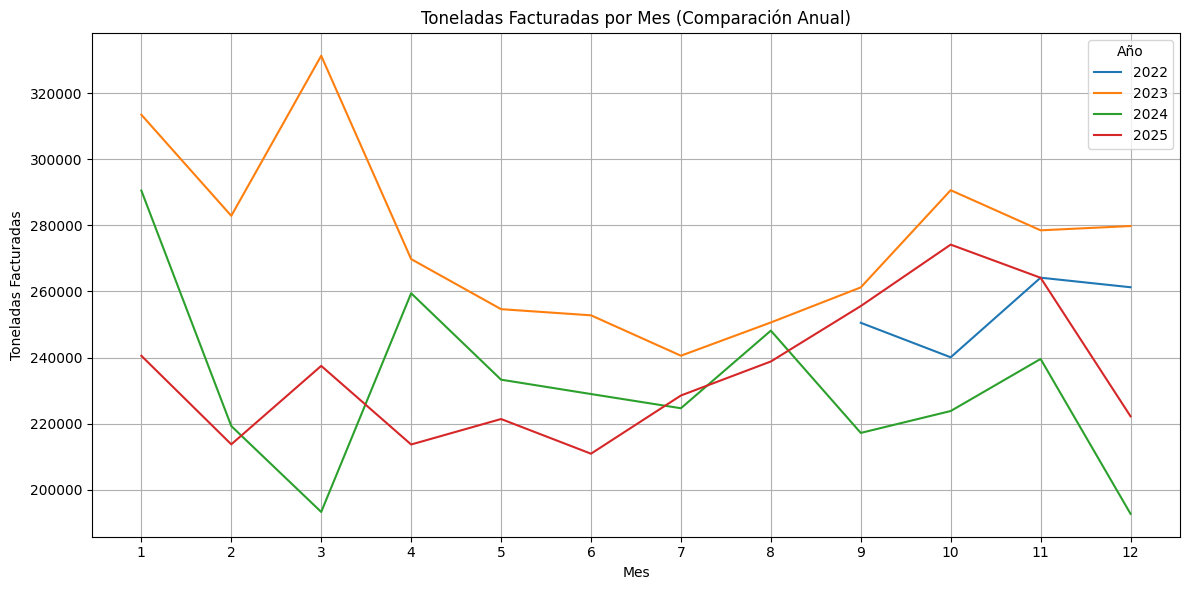

In [161]:
import pandas as pd
import matplotlib.pyplot as plt

x = data.set_index("id").groupby("mes_anio").sum().reset_index()
x.toneladas_facturadas = np.where(x.mes_anio >= date_tdy,x.toneladas_pvo, x.toneladas_facturadas)
x

# Supongamos que ya tienes tu DataFrame con el índice como fecha y una columna 'toneladas_facturadas'
# Asegúrate de que el índice esté en formato datetime
def plot_year(df, col = 'toneladas_facturadas'):
    #df = df.copy()
    #df.index = pd.to_datetime(df.index)

    # Extraer año y mes
    df['Año'] = df.mes_anio.dt.year
    df['Mes'] = df.mes_anio.dt.month

    # Pivotear para tener los meses como eje x y los años como líneas
    pivot_df = df.pivot_table(index='Mes', columns='Año', values=col)

    # Graficar
    plt.figure(figsize=(12, 6))
    for year in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[year], label=str(year))

    plt.title('Toneladas Facturadas por Mes (Comparación Anual)')
    plt.xlabel('Mes')
    plt.ylabel('Toneladas Facturadas')
    plt.xticks(range(1, 13))
    plt.legend(title='Año')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_year(x)

### 1) Análisis de PVO vs Deuda vs Fact

las condiciones para entrar a este analisis son las siguientes : 
* son SKU-PL que tienen registros suficientes (+6)
* Tienen almenos 1 facturación en los ultimos 6m
* Cuentan con pronostico de venta

en total son 6.0K Indicadores los cuales se analizan para

1) Encontrar aquellos que sean propensos a tener errores en Deuda/PVO
2) Analisis de Clustering para encontrar aquellos productos/SKUs que se comporten como series de tiempo
3) Otros

<Axes: xlabel='count_mcc'>

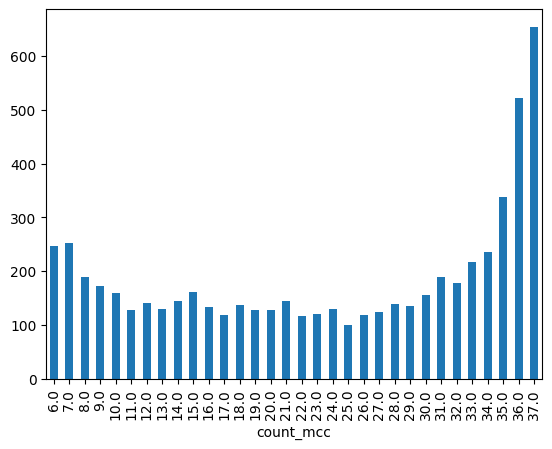

In [133]:
# distribución de OBSERVACIONES
id_a1 = tabla_arbol[tabla_arbol.analisis == "Analisis de PVO vs Deuda vs Facturación"].id.unique()  

# vista 1 barplot
tabla_arbol[tabla_arbol.id.isin(id_a1)].count_mcc.value_counts().sort_index().plot(kind= "bar")

<Axes: xlabel='mes_anio'>

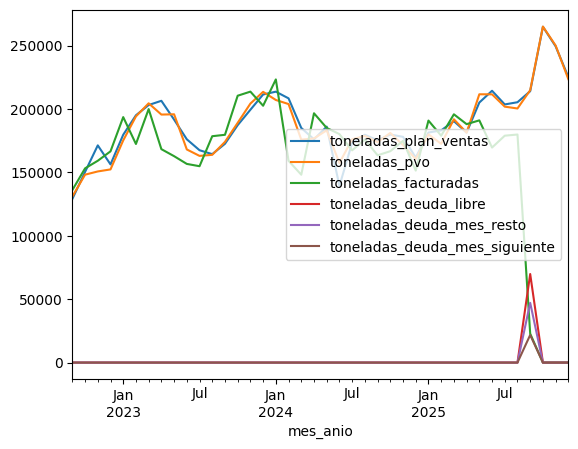

In [257]:
# comparacion de volumen
data[data.id.isin(id_a1)].groupby("mes_anio").agg({"toneladas_plan_ventas":"sum", "toneladas_pvo" :"sum", "toneladas_facturadas":"sum", "toneladas_deuda_libre":"sum", "toneladas_deuda_mes_resto": "sum", "toneladas_deuda_mes_siguiente": "sum"}).plot()

In [258]:
import pandas as pd

# Cargar tus datos
df = data_[data_.id.isin(id_a1)].groupby(["mes_anio", "id"]).toneladas_facturadas.sum().reset_index()  # Asegúrate de tener las columnas: id, mes_anio, toneladas_facturadas

df = df[df['toneladas_facturadas'] > 0]  # Filtrar solo las filas con toneladas_facturadas > 0

comb_tot = df.id.nunique()

print("total de combinaciones de PL & SKU :{}".format(comb_tot))

# Convertir mes_anio a formato de fecha
df['mes_anio'] = pd.to_datetime(df['mes_anio'], format='%Y-%m')

df = df.loc[df["mes_anio"] < date_tdy, :]  # Filtrar por fecha si es necesario

print(df.mes_anio.max())

# Crear todas las combinaciones posibles de id y mes_anio
ids = df['id'].unique()

# imputar ceros
meses = pd.date_range(start=df['mes_anio'].min(), end=df['mes_anio'].max(), freq='MS')

# crar combinacion mes id para colocar datos.
combinaciones = pd.MultiIndex.from_product([ids, meses], names=['id', 'mes_anio'])

# Reindexar y rellenar con 0 donde no haya facturación
df_completo = df.set_index(['id', 'mes_anio']).reindex(combinaciones, fill_value=0).reset_index()

total de combinaciones de PL & SKU :5983
2025-08-01 00:00:00


In [260]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters 

settings = ComprehensiveFCParameters()


# Definir parámetros personalizados para tsfresh


selected_features = {
    'linear_trend': [ {'attr': 'pvalue'}, {'attr': 'slope'}], #{'attr': 'intercept'}
    'autocorrelation': [{'lag': i} for i in range(0, 13)],
    'fft_coefficient': [{'coeff': i, 'attr': 'abs'} for i in range(0, 18)],
    'standard_deviation': None,
    'approximate_entropy': [{'m': 2, 'r': 0.2}],
    'skewness': None,
    'kurtosis': None,
    'augmented_dickey_fuller': [{'attr': 'pvalue'}],
    'binned_entropy': [{'max_bins': 12}],
    'cid_ce': [{'normalize': True}],
    #'length': None,
    'count_above_mean': None,
    #'count_below_mean': None,
    'number_peaks': [{'n': 5}],
    'variation_coefficient': None,
    'value_count': [{'value': 0}]  # Conteo explícito de ceros
    }

X = extract_features(df_completo.iloc[:,:3], 
                     column_id='id', 
                     column_sort='mes_anio',
                     default_fc_parameters=selected_features,
                     # we impute = remove all NaN features automatically
                     impute_function=impute)

print(X.shape)

# Eliminamos columnas con valores unicos ["repetidos entre todas las series"]
X = X.drop(columns = X.columns[X.apply(lambda x: x.nunique())== 1].values)

print(X.shape)

Feature Extraction: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


(5983, 44)
(5983, 44)


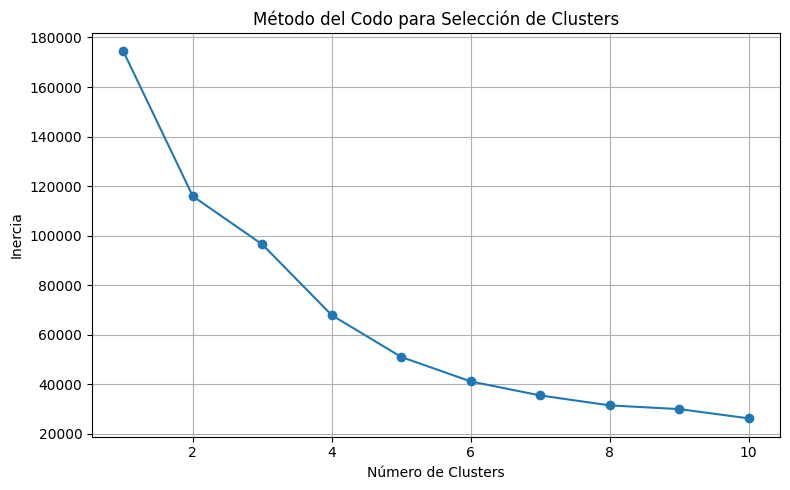

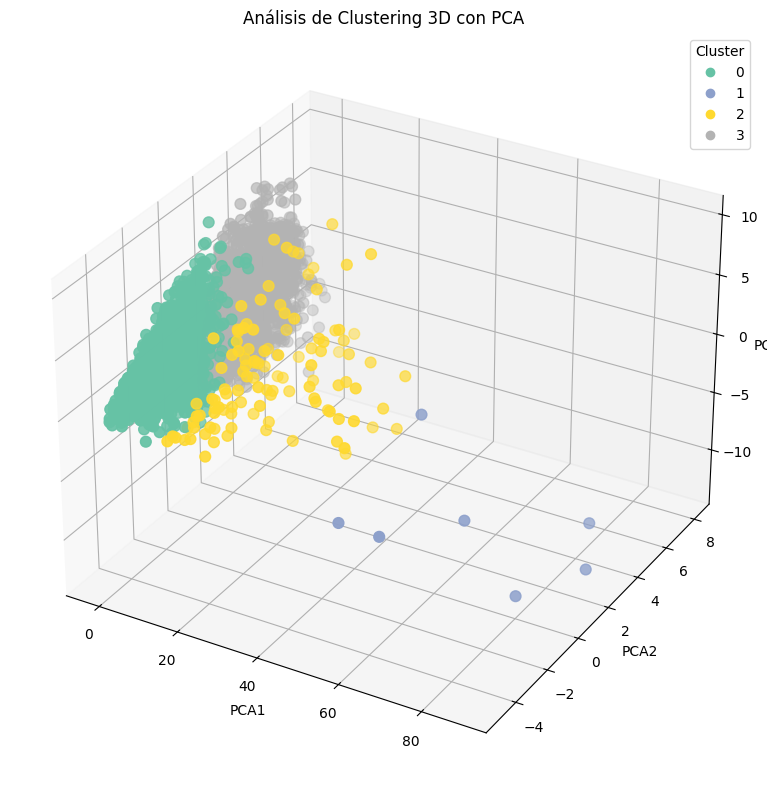

'\nprint("Ranking de variables más importantes para el clustering:")\nfor i, (feature, score) in enumerate(sorted_features[:11], 1):\n    print(f"{i}. {feature} \t  (F-score:{score:.2f})")\n    sns.violinplot(data = X, y = feature, x = "Cluster" , hue ="Cluster" )\n    display(X.groupby("Cluster")[feature].describe())\n    plt.show()\n    '

In [275]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Escalar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

# Aplicar PCA con 4 componentes
pca = PCA(n_components=3)
pca_components = pca.fit_transform(scaled_data)

# Método del codo para determinar el número óptimo de clusters
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_components)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Método del Codo para Selección de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)
plt.tight_layout()
plt.savefig("metodo_del_codo.png")

# Aplicar KMeans con 3 clusters como ejemplo
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(pca_components)

# Agregar componentes PCA y etiquetas de cluster al DataFrame
X['PCA1'] = pca_components[:, 0]
X['PCA2'] = pca_components[:, 1]
X['PCA3'] = pca_components[:, 2]
X['Cluster'] = clusters

# Gráfico 3D de dispersión
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X['PCA1'], X['PCA2'], X['PCA3'],
                     c=X['Cluster'], cmap='Set2', s=60)
ax.set_title('Análisis de Clustering 3D con PCA')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.tight_layout()
plt.savefig("clustering_3d.png")
plt.show()

from scipy.stats import f_oneway


# Evaluar importancia de variables usando ANOVA (F-test)
feature_scores = {}
for col in X.columns[:-4]:  # Excluir la columna de clúster
    groups = [group[col].values for name, group in X.groupby('Cluster')]
    f_stat, p_val = f_oneway(*groups)
    feature_scores[col] = f_stat

# Ordenar las variables por importancia (F-score descendente)
sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

# Mostrar resultados
"""
print("Ranking de variables más importantes para el clustering:")
for i, (feature, score) in enumerate(sorted_features[:11], 1):
    print(f"{i}. {feature} \t  (F-score:{score:.2f})")
    sns.violinplot(data = X, y = feature, x = "Cluster" , hue ="Cluster" )
    display(X.groupby("Cluster")[feature].describe())
    plt.show()
    """

In [267]:
# Mostrar resultados
print("Ranking de variables más importantes para el clustering:")
for i, (feature, score) in enumerate(sorted_features[:11], 1):
    print(f"{i}. {feature} \t  (F-score:{score:.2f})")
    #sns.violinplot(data = X, y = feature, x = "Cluster" , hue ="Cluster" )
    #display(X.groupby("Cluster")[feature].describe())
    plt.show()

Ranking de variables más importantes para el clustering:
1. toneladas_facturadas__standard_deviation 	  (F-score:5538.72)
2. toneladas_facturadas__fft_coefficient__attr_"abs"__coeff_8 	  (F-score:4349.76)
3. toneladas_facturadas__fft_coefficient__attr_"abs"__coeff_10 	  (F-score:3711.67)
4. toneladas_facturadas__fft_coefficient__attr_"abs"__coeff_0 	  (F-score:3679.45)
5. toneladas_facturadas__fft_coefficient__attr_"abs"__coeff_11 	  (F-score:3367.62)
6. toneladas_facturadas__fft_coefficient__attr_"abs"__coeff_5 	  (F-score:3353.93)
7. toneladas_facturadas__fft_coefficient__attr_"abs"__coeff_4 	  (F-score:3265.78)
8. toneladas_facturadas__fft_coefficient__attr_"abs"__coeff_15 	  (F-score:3264.39)
9. toneladas_facturadas__binned_entropy__max_bins_12 	  (F-score:3083.95)
10. toneladas_facturadas__fft_coefficient__attr_"abs"__coeff_9 	  (F-score:2999.43)
11. toneladas_facturadas__fft_coefficient__attr_"abs"__coeff_6 	  (F-score:2992.99)


In [ ]:
analisis1 = data[data.id.isin(X.index)].copy()
"""
analisis1["MAPE_PVO"] = np.where(
                        (analisis1.toneladas_facturadas < 1) & (analisis1.toneladas_pvo < 1), 0,
                        np.where(
                            ((analisis1.toneladas_facturadas < 1) & (analisis1.toneladas_pvo >= 1)) | ((analisis1.toneladas_facturadas >= 1) & (analisis1.toneladas_pvo < 1)), 1,
                            np.where(
                                (analisis1.toneladas_facturadas >= 1) & (analisis1.toneladas_pvo >= 1),
                                np.abs(analisis1.toneladas_facturadas - analisis1.toneladas_pvo) / np.where(analisis1.toneladas_pvo != 0, analisis1.toneladas_pvo, 1),  # Evita división por cero
                                0
                            )
                        )
                    )

"""
#analisis1["MAPE_PVO"] = np.minimum(analisis1["MAPE_PVO"],2)

analisis1 = analisis1[analisis1.mes_anio < date_tdy]

analisis1["Cluster"] = analisis1.id.map(X.Cluster.to_dict())

tabla_arbol["CLUSTER"] =  tabla_arbol["id"].map( analisis1.set_index("id").Cluster.to_dict()).fillna(4)

data["CLUSTER"] =  data["id"].map( analisis1.set_index("id").Cluster.to_dict()).fillna(4)

data["ANALISIS"] =  data["id"].map( tabla_arbol.set_index("id").analisis.to_dict()).fillna(4)

analisis1["mcc"] = np.where(analisis1.toneladas_facturadas> 0.001, 1, 0)

analisis1

,id,mes_anio,toneladas_facturadas,toneladas_deuda_libre,toneladas_deuda_mes_resto,toneladas_deuda_mes_siguiente,toneladas_plan_ventas,toneladas_pvo,MAPE_PVO,WMAPE_PVO,Cluster,mcc
477,"ACERÍA CELAYA_SKU_ALAMBRON 1/4"" CONST BYM C 1.4T",2022-09-01,447.11600,0.0,0.0,0.0,340.85700,340.85700,0.311741,139.384255,2,1
478,"ACERÍA CELAYA_SKU_ALAMBRON 1/4"" CONST BYM C 1.4T",2022-10-01,295.94200,0.0,0.0,0.0,642.42000,642.42000,0.539333,159.611146,2,1
479,"ACERÍA CELAYA_SKU_ALAMBRON 1/4"" CONST BYM C 1.4T",2022-11-01,705.52100,0.0,0.0,0.0,768.70200,768.70200,0.082192,57.988040,2,1
480,"ACERÍA CELAYA_SKU_ALAMBRON 1/4"" CONST BYM C 1.4T",2022-12-01,776.80000,0.0,0.0,0.0,636.52300,636.52300,0.220380,171.191259,2,1
481,"ACERÍA CELAYA_SKU_ALAMBRON 1/4"" CONST BYM C 1.4T",2023-01-01,665.70000,0.0,0.0,0.0,983.06800,983.06894,0.322835,214.911177,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
653986,VIRTUAL AZZ HURST_SKU_GALVANIZED SOLAR PIERS 6...,2025-04-01,19.59400,0.0,0.0,0.0,0.00000,0.00000,1.000000,19.594000,3,1
653987,VIRTUAL AZZ HURST_SKU_GALVANIZED SOLAR PIERS 6...,2025-05-01,14.69644,0.0,0.0,0.0,0.00000,0.00000,1.000000,14.696440,3,1
653988,VIRTUAL AZZ HURST_SKU_GALVANIZED SOLAR PIERS 6...,2025-06-01,16.69200,0.0,0.0,0.0,21.50335,21.50335,0.223749,3.734816,3,1
653989,VIRTUAL AZZ HURST_SKU_GALVANIZED SOLAR PIERS 6...,2025-07-01,0.36300,0.0,0.0,0.0,93.84634,93.84634,1.000000,0.363000,3,1


Gráfico guardado como 'kpi_cluster_grid_extended.png'


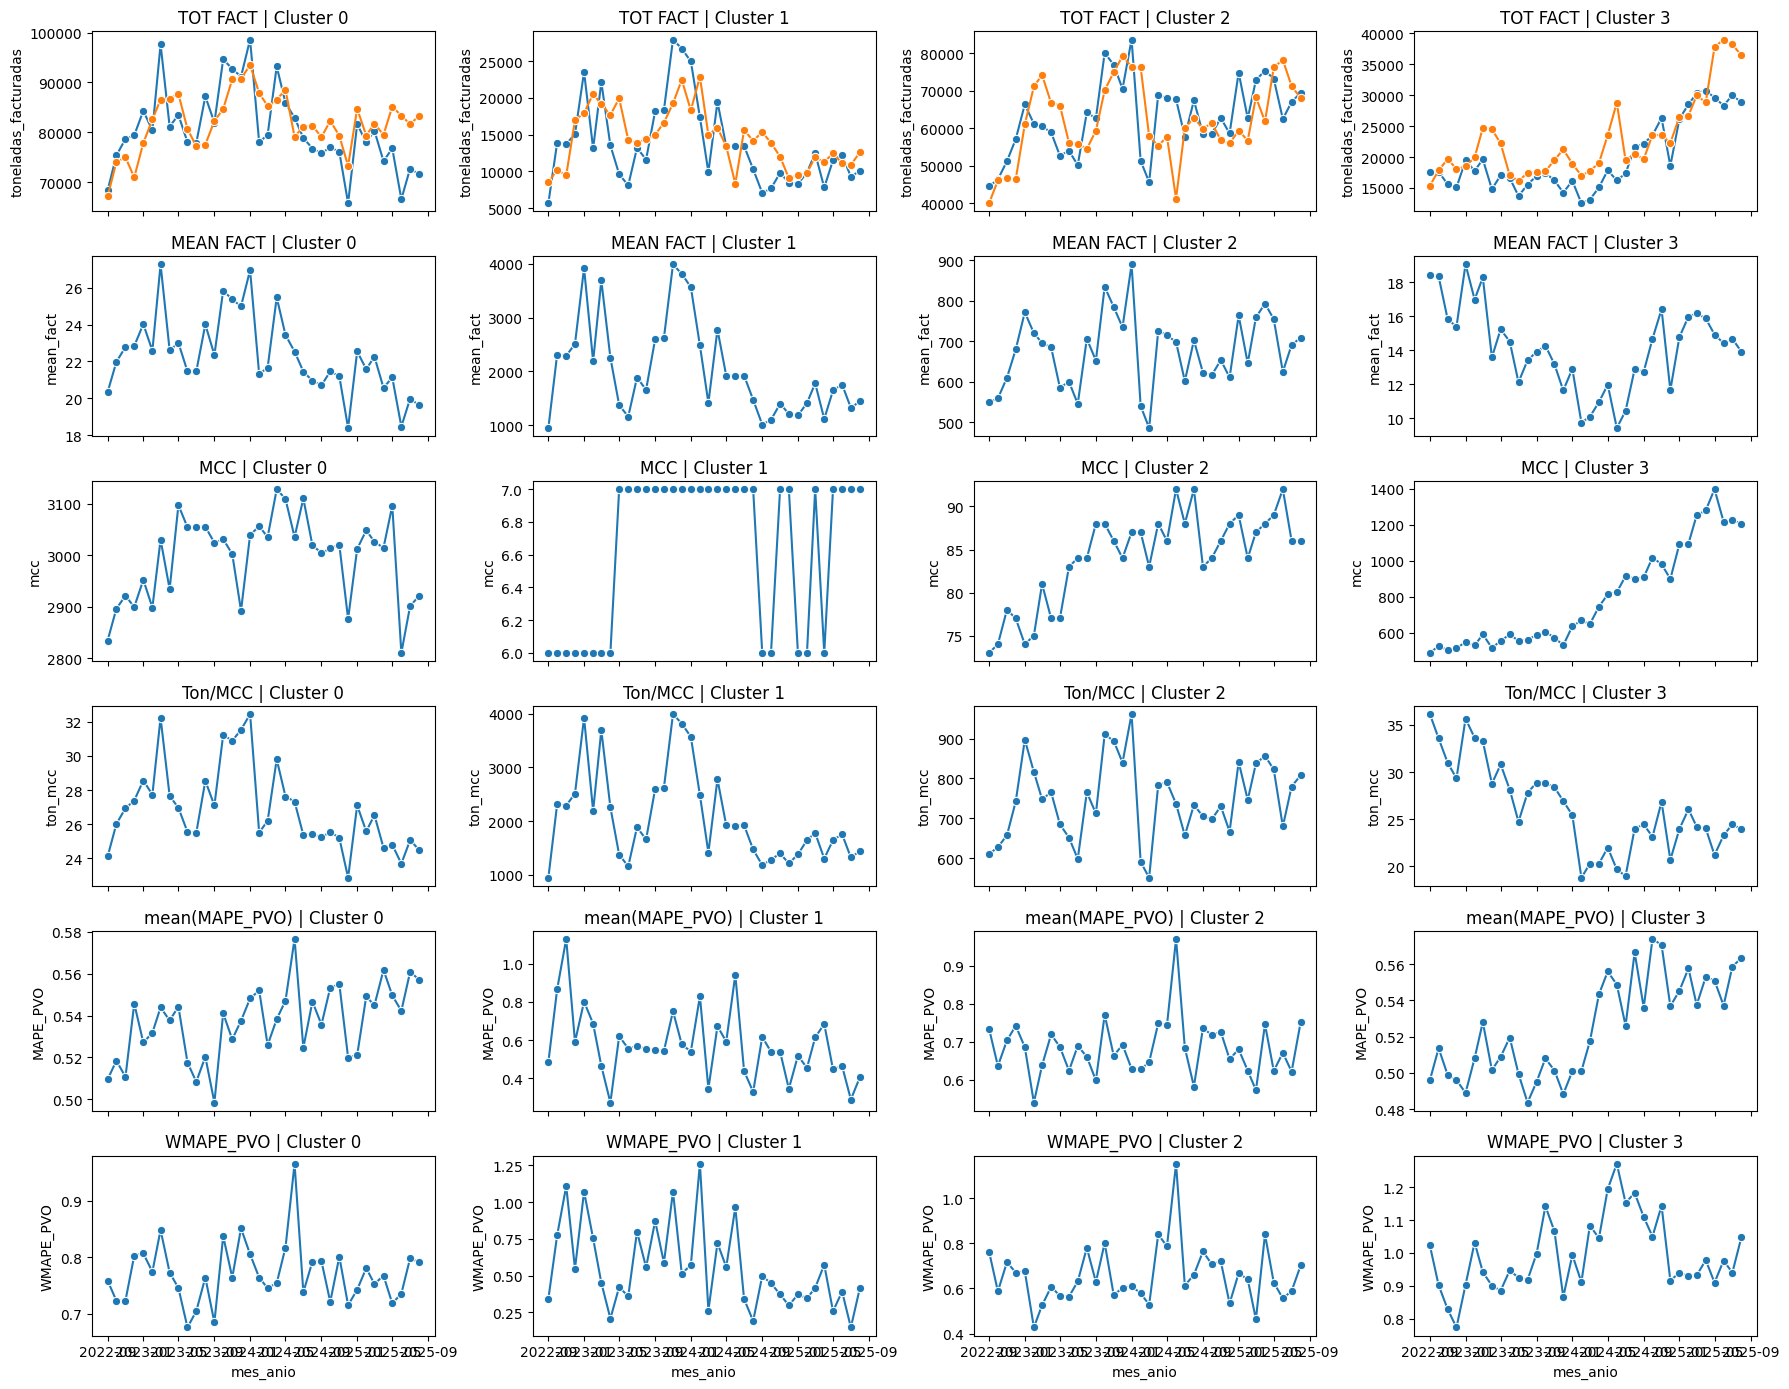

In [ ]:
tab_analisis = analisis1.groupby(["Cluster", "mes_anio"]).agg({"toneladas_facturadas": ["sum", "mean"], "toneladas_pvo":["sum", "mean"],"mcc":"sum", "MAPE_PVO" : "mean", "WMAPE_PVO" : "sum"}).reset_index()

tab_analisis.columns = ["Cluster", "mes_anio", "toneladas_facturadas", "mean_fact","pvo_tot","pvo_mean", "mcc", "MAPE_PVO", "WMAPE_PVO"] 

tab_analisis["WMAPE_PVO"] = tab_analisis["WMAPE_PVO"].div(tab_analisis["toneladas_facturadas"])  

tab_analisis["ton_mcc"] = tab_analisis.toneladas_facturadas.div(tab_analisis.mcc) 

# Crear figura con 3 filas (KPIs) y 3 columnas (Clusters)
n = 4
fig, axes = plt.subplots(6, n, figsize=(18, 14), sharex=True)

# KPIs y títulos
kpis = ["toneladas_facturadas","mean_fact", "mcc", "ton_mcc", "MAPE_PVO", "WMAPE_PVO"]

kpi_titles = ["TOT FACT" ,"MEAN FACT","MCC", "Ton/MCC", "mean(MAPE_PVO)", "WMAPE_PVO"]

# Graficar cada KPI por cluster
for i, kpi in enumerate(kpis):

    for j in range(n):
        cluster_data = tab_analisis[tab_analisis["Cluster"] == j]
        
        if kpi =="toneladas_facturadas":  
            sns.lineplot(ax=axes[i, j], data=cluster_data.fillna(0), x="mes_anio", y="toneladas_facturadas", marker="o")
            sns.lineplot(ax=axes[i, j], data=cluster_data.fillna(0), x="mes_anio", y="pvo_tot", marker="o")
        else :
            sns.lineplot(ax=axes[i, j], data=cluster_data, x="mes_anio", y=kpi, marker="o")

        axes[i, j].set_title(f"{kpi_titles[i]} | Cluster {j}")
# 
plt.tight_layout()
plt.savefig("kpi_cluster_grid_extended.png")
print("Gráfico guardado como 'kpi_cluster_grid_extended.png'")

In [340]:
tabla_arbol["DIST_PVO_TON6M"] = tabla_arbol ["toneladas_pvo"] - tabla_arbol["PVO_6M_MEAN"]

tabla_arbol["DIST_PVO_TON6M_ABS"] = (tabla_arbol ["toneladas_pvo"] - tabla_arbol["PVO_6M_MEAN"]).abs()

tabla_arbol["RANK"] = tabla_arbol.groupby(["analisis", "CLUSTER"]).DIST_PVO_TON6M_ABS.rank(method = "dense", ascending=False)

tabla_arbol["DIST_PVO_TON6M_PP"] = (tabla_arbol ["toneladas_pvo"] - tabla_arbol["PVO_6M_MEAN"]) /tabla_arbol ["toneladas_pvo"]

tabla_arbol.to_excel(r".\outputs\resultados_arbol.xlsx", index = False)

In [ ]:
# 

data["CLUSTER"] =  data["id"].map( analisis1.set_index("id").Cluster.to_dict()).fillna(4)

data["ANALISIS"] =  data["id"].map( tabla_arbol.set_index("id").analisis.to_dict()).fillna("SC")

#data.to_csv(r".\outputs\alertas_series.csv" ,index = False)

tabla_arbol["ACTUALIZACION"] = date

tabla_arbol.to_csv(r".\outputs\resultados_arbol.csv", index = False)

In [ ]:
id_d = catalogo_id.groupby("id").first()


tabla_arbol.merge(id_d, how = "left", on = "id", validate= "1:1")
tabla_arbol["ANIO_6M_UNIQUE"].fillna.apply(lambda x: np.nan if len(x) > 0 else ",".join(x) 
)

TypeError: can only join an iterable

In [ ]:

from pandas_gbq import to_gbq

# Parámetros
project_id = "common-prj-sandbox"
dataset_id = "Dev_AldoOjeda"
table_name = "dev_alertas_pvo"
full_table_id = f"{dataset_id}.{table_name}"

catalogo_id

# Subir el DataFrame
to_gbq(tabla_arbol, full_table_id, project_id=project_id, if_exists="replace")

100%|██████████| 1/1 [00:00<?, ?it/s]


# FALTA DESARROLLO DEL DASHBOARD
 AGREGAR INFORMACION HISTORICA CON ALERTAS/SKU

Participación de volumen por ubicación
Cantidad de PL con volumen: 173


<Axes: title={'center': '% de Toneladas Facturadas por Ubicación'}, ylabel='nom_ubicacion'>

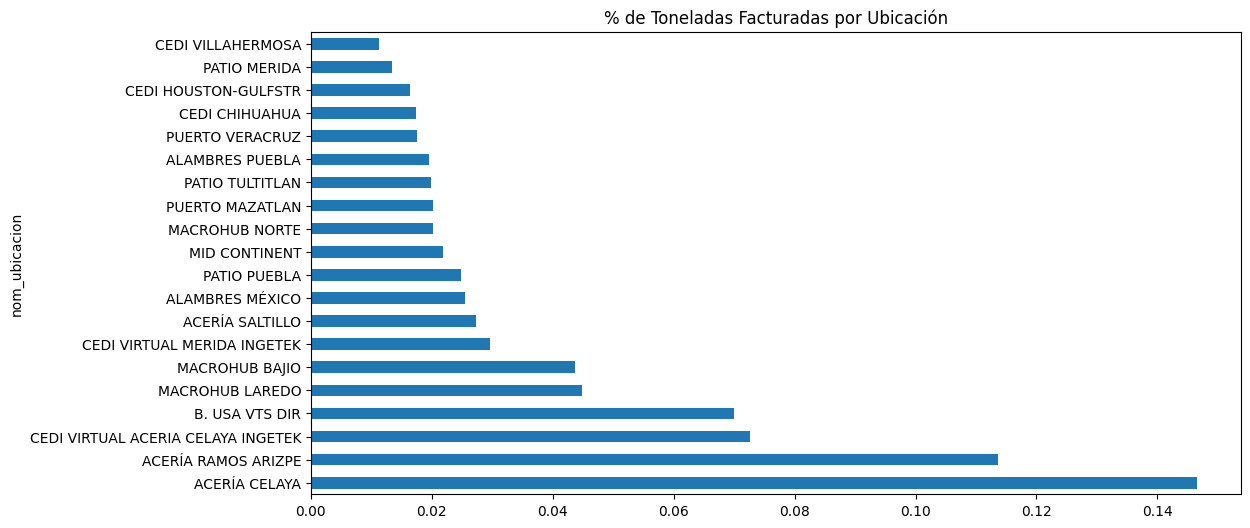

In [ ]:
print("Participación de volumen por ubicación")

print("Cantidad de PL con volumen: {}".format(data_.nom_ubicacion.nunique()))

data.groupby("nom_ubicacion").toneladas_facturadas.sum().div(data_.toneladas_facturadas.sum()).sort_values(ascending=False).head(20).plot(kind='barh', figsize=(12, 6), title='% de Toneladas Facturadas por Ubicación')


In [273]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import hashlib
from datetime import datetime


# ------------------------------------------------------
date = datetime.now().date()
# ------------------------------------------------------
m, y = date.month, date.year
# ------------------------------------------------------
min_date = date.replace(year= y-1, month = m, day = 1)

min_date_2 = date.replace(year= y-2, month = m, day = 1)

max_date = date.replace( month = m-1, day = 1)

actual_date = date.replace(day = 1)

min_date, max_date, actual_date

(datetime.date(2024, 9, 1),
 datetime.date(2025, 8, 1),
 datetime.date(2025, 9, 1))

In [274]:
var= "toneladas_plan_ventas"

var2del = "toneladas_pvo"

pvo = pd.read_csv(r".\consultas\pvo.csv", engine="pyarrow")

pvo.nom_familia_asociada = pvo.nom_familia_asociada.str.replace(r'\s+|\t+', ' ', regex=True)

pvo.nom_ubicacion = pvo.nom_ubicacion.str.replace(r'\s+|\t+', ' ', regex=True)

pvo["Base"] = "pvo"

pvo = pvo.drop(columns= ["toneladas_dim_capacidades", var2del]) #"toneladas_pvo"

print(pvo.shape)

pvo = pvo.dropna(subset = [var, "nom_articulo", "nom_ubicacion"], how="any")

print(pvo.shape)

pvo["MesAct_fact"] = False

(1210784, 13)
(128244, 13)


<Axes: xlabel='MesAnio'>

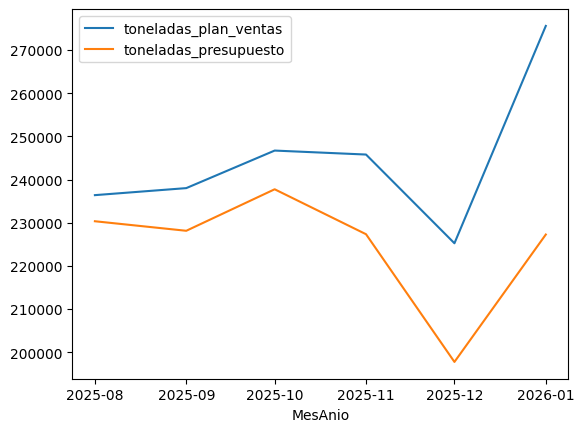

In [5]:
pvo.groupby("MesAnio").agg({"toneladas_plan_ventas":"sum", "toneladas_presupuesto" :"sum"}).plot()

In [6]:
fact = pd.read_csv(r".\consultas\fact.csv", engine="pyarrow")

fact.nom_familia_asociada = fact.nom_familia_asociada.str.replace(r'\s+|\t+', ' ', regex=True)

fact.nom_ubicacion = fact.nom_ubicacion.str.replace(r'\s+|\t+', ' ', regex=True)

fact["Base"] = "fact"

fact = fact[(fact.MesAnio >= min_date_2) & (fact.MesAnio >= min_date_2) ]

fact["MesAct_fact"] = np.where( fact.MesAnio == actual_date, True, False)

fact.nom_familia_asociada = np.where(fact.nom_familia_asociada.isna(), fact.nom_articulo, fact.nom_familia_asociada) 

fact.MesAnio.nunique()

20

In [162]:
x

,mes_anio,toneladas_facturadas,toneladas_deuda_libre,toneladas_deuda_mes_resto,toneladas_deuda_mes_siguiente,toneladas_plan_ventas,toneladas_pvo,MAPE_PVO,WMAPE_PVO,Año,Mes
0,2022-09-01,250522.458530,0.000000,0.000000,0.000000,240372.174000,242070.59000,7608.690596,212601.491934,2022,9
1,2022-10-01,240092.849048,0.000000,0.000000,0.000000,256588.738000,257598.18100,7560.365231,191964.405189,2022,10
2,2022-11-01,264161.711156,0.000000,0.000000,0.000000,293740.965000,295699.06500,7529.344271,220563.353228,2022,11
3,2022-12-01,261270.608146,0.000000,0.000000,0.000000,273995.597000,260147.87900,7570.172464,212562.011876,2022,12
4,2023-01-01,313430.618742,0.000000,0.000000,0.000000,312528.141000,298882.43117,7543.366225,269343.468691,2023,1
5,2023-02-01,282863.453461,0.000000,0.000000,0.000000,324150.797240,315952.64114,7517.291982,213272.473003,2023,2
6,2023-03-01,331272.298213,0.000000,0.000000,0.000000,336808.929160,334046.90759,8025.935110,261380.037897,2023,3
7,2023-04-01,269785.404762,0.000000,0.000000,0.000000,340532.613710,320518.66467,7645.491625,200245.881452,2023,4
8,2023-05-01,254641.377198,0.000000,0.000000,0.000000,299670.119180,302276.42556,7686.133090,197222.117795,2023,5
9,2023-06-01,252783.123758,0.000000,0.000000,0.000000,297406.499390,274738.17080,7879.907324,192407.737814,2023,6


C:\Users\adojeda\AppData\Local\Temp\ipykernel_2884\2220778978.py:36: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_d = kpss(detrend_serie.dropna(), regression='c')
c:\Users\adojeda\OneDrive - deacero.com\dev\0_envs\.bigquery\Lib\site-packages\statsmodels\tsa\filters\hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


Resultados de pruebas estadísticas:

ADF p-value: 0.0271 (H0: no estacionaria)
KPSS p-value: 0.0174 (H0: estacionaria)
Ljung-Box p-value: 0.0001 (H0: no autocorrelación)
ADF p-value: 0.0000 (H0: no estacionaria)
KPSS p-value: 0.1000 (H0: estacionaria)
Ljung-Box p-value: 0.0657 (H0: no autocorrelación)
Chow Test p-value: 0.3896 (H0: sin ruptura estructural)


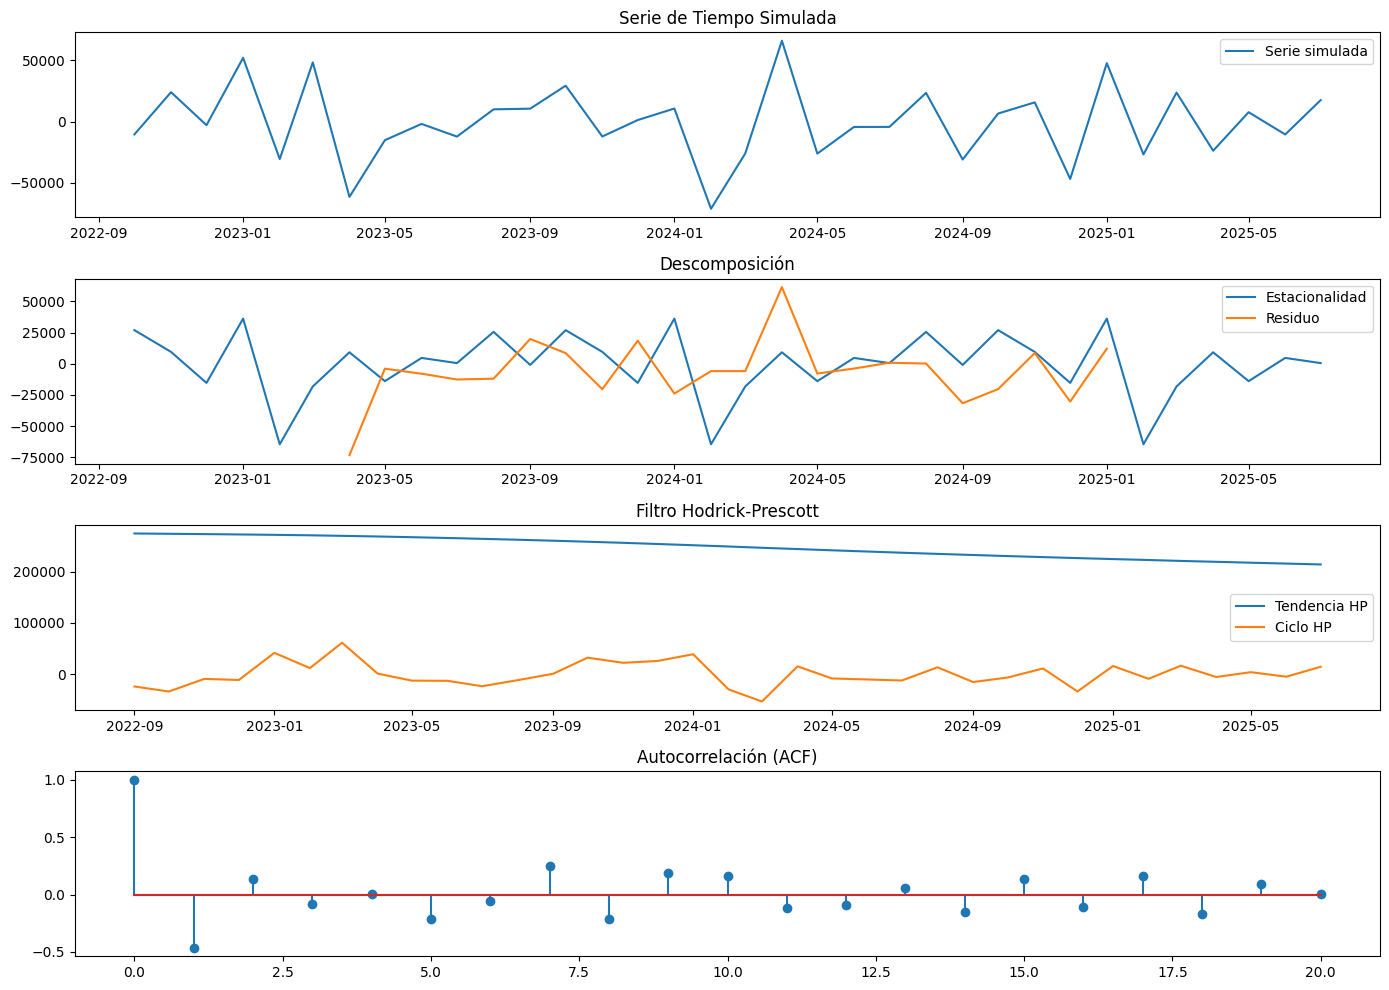

In [366]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from scipy.stats import norm

# Simular datos de series de tiempo con varios comportamientos
np.random.seed(42)
periods = 35
trend = np.linspace(10, 50, periods)
seasonality = 10 * np.sin(np.linspace(0, 3 * np.pi, periods))
noise = np.random.normal(0, 2, periods)
structural_break = np.array([5 if i > 60 else 0 for i in range(periods)])

data = trend + seasonality + noise + structural_break
tf = x.set_index("mes_anio").toneladas_facturadas[:35]

dates = tf.index
series = tf
detrend_serie = (series - series.shift(1)).dropna()
 

# Descomposición de la serie
decomposition = seasonal_decompose(detrend_serie, model='additive')

# Pruebas estadísticas
adf_result = adfuller(series)
adf_result_d = adfuller(detrend_serie.dropna())
kpss_result = kpss(series, regression='c')
kpss_result_d = kpss(detrend_serie.dropna(), regression='c')
ljung_box_result = acorr_ljungbox(series, lags=[12], return_df=True)
ljung_box_result_d = acorr_ljungbox(detrend_serie, lags=[12], return_df=True)

# Filtro HP para detectar ciclos
cycle, trend_hp = hpfilter(series, lamb=1600)

# Chow Test simulado: comparar regresión antes y después del punto de quiebre
break_point = 15
X1 = add_constant(np.arange(break_point))
X2 = add_constant(np.arange(periods - break_point - 1))
model1 = OLS(detrend_serie[:break_point], X1).fit()
model2 = OLS(detrend_serie[break_point:], X2).fit()
RSS1 = sum(model1.resid ** 2)
RSS2 = sum(model2.resid ** 2)
RSS_combined = sum(OLS(detrend_serie, add_constant(np.arange(periods-1))).fit().resid ** 2)
k = 2  # número de parámetros
chow_stat = ((RSS_combined - (RSS1 + RSS2)) / k) / ((RSS1 + RSS2) / (periods - 2 * k))
p_value_chow = 1 - norm.cdf(chow_stat)

# Visualizaciones
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(detrend_serie, label='Serie simulada')
plt.title('Serie de Tiempo Simulada')
plt.legend()

plt.subplot(412)
#plt.plot(decomposition.trend, label='Tendencia')
plt.plot(decomposition.seasonal, label='Estacionalidad')
plt.plot(decomposition.resid, label='Residuo')
plt.title('Descomposición')
plt.legend()

plt.subplot(413)
plt.plot(trend_hp, label='Tendencia HP')
plt.plot(cycle, label='Ciclo HP')
plt.title('Filtro Hodrick-Prescott')
plt.legend()

plt.subplot(414)
plt.stem(acf(detrend_serie, nlags=20))
plt.title('Autocorrelación (ACF)')

plt.tight_layout()
plt.savefig("temporal_analysis_notebook.png")

# Resultados de pruebas
print("Resultados de pruebas estadísticas:\n")
print(f"ADF p-value: {adf_result[1]:.4f} (H0: no estacionaria)")
print(f"KPSS p-value: {kpss_result[1]:.4f} (H0: estacionaria)")
print(f"Ljung-Box p-value: {ljung_box_result.iloc[0, 1]:.4f} (H0: no autocorrelación)")

print(f"ADF p-value: {adf_result_d[1]:.4f} (H0: no estacionaria)")
print(f"KPSS p-value: {kpss_result_d[1]:.4f} (H0: estacionaria)")
print(f"Ljung-Box p-value: {ljung_box_result_d.iloc[0, 1]:.4f} (H0: no autocorrelación)")

print(f"Chow Test p-value: {p_value_chow:.4f} (H0: sin ruptura estructural)")

# Estadistica Descriptiva PL

Con este análisis se busca contestar a las siguientes preguntas: 
* Existen PL parecidos?

In [ ]:
# Estadistica Descriptiva PL

data_[data_.mes_anio <= "2024-09-01" ].groupby(["nom_ubicacion","mes_anio", "nom_grupo"]).agg({"toneladas_facturadas":"sum","nom_articulo":"nunique"})

#data_




toneladas_facturadas  nom_articulo
nom_ubicacion     mes_anio                                      
3PL COATZACOALCOS 2022-09-01               0.00000             1
                  2022-12-01              88.26000             1
                  2023-01-01             385.59000             2
                  2023-02-01             476.08000             3
                  2023-03-01            1660.85000             4
...                                            ...           ...
WEST MEMPHIS DC.  2024-05-01             126.55600            80
                  2024-06-01             315.99220           160
                  2024-07-01              62.85436           111
                  2024-08-01             852.65200           109
                  2024-09-01             100.97156           112

[3075 rows x 2 columns]